<H1>SetUp

<H3>Import Dependencies

In [1]:
#Import standard Libraries
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Import tensorflow Libraries - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

<H3>Set GPU growth

In [3]:
#Avoid OOM errors by setting GPU Memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[]

<h3>Create Folder Structures

In [4]:
#Setup path
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
#Create Directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [6]:
#Get current working directory
os.getcwd()

'C:\\Users\\madhu\\openvino_notebooks\\notebooks'

<H1>Collect Positives and Anchors

<H3>2. Labelled objects dataset

<H3>2.1 Uncompress tar GZ file

In [7]:
#http://vis-www.cs.umass.edu/lfw/

In [8]:
# !tar -xf lfw.tgz
#Uncomment to uncompress

In [9]:
#Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

<h3>2.2 Collect Positive and Anchor Classes

In [5]:
import uuid

In [41]:
#Establish a connection and Access webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    #Cut Frame to get images in 250x250 frame
    frame[200:200+250, 270:270+250, :]
    
    #Collect Anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #Create a unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write out anchor image
        cv2.imwrite(imgname, frame)
    
    #Collect Positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #Create a unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write out positive image
        cv2.imwrite(imgname, frame)
    
    #Show Image on Screen
    cv2.imshow('Image Collection', frame)
    
    #Break Control
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
#Release Webcam
cap.release()
#Close Image Show Frame
cv2.destroyAllWindows()

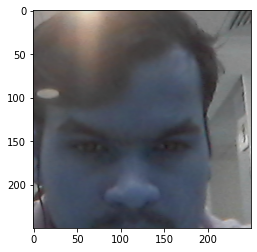

In [38]:
#Resize image
plt.imshow()

<h1>3. Load and Preprocess Images

<h3>3.1 Get Image Directions

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [7]:
dir_test = anchor.as_numpy_iterator()

In [8]:
dir_test.next()

b'data\\anchor\\f02fd0d0-7624-11ed-9104-803049b7681e.jpg'

<h3>3.2 Preprocessing - Scale and Resize

In [9]:
def preprocess(file_path):
    
    #Read in Image from file path
    byte_img = tf.io.read_file(file_path)
    
    #Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    #Preprocessing steps - resiziing image to be (100*100*3)
    img = tf.image.resize(img, (100,100))
    
    #Scale image to be between 0 and 1
    img = img / 255.0
    
    #Return image
    return img

<h3>3.3 Create Labelled Dataset

In [10]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

<h3>3.4 Build Train and Test Partition

In [14]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)


#Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

TypeError: in user code:

    File "<ipython-input-12-47a48a190c43>", line 2, in preprocess_twin  *
        return (preprocess(input_img), preprocess(validation_img), label)
    File "<ipython-input-9-d5398deac772>", line 4, in preprocess  *
        byte_img = tf.io.read_file(file_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [15]:
#Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [16]:
#Testing Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

<h1>4 Model Engineering

<h3>4.1 Building Embedding Layer

In [25]:
def embedding_layer():
    inp = Input(shape = (100,100,3), name = 'input_image')
    
    #First Block
    c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)
    
    #Second Block
    c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)
    
    #Third Block
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)
    
    #Final Block
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    #Return Model
    return Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [26]:
embedding = embedding_layer()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 128)       26

<h3>4.2 Building Distance Layer

In [27]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

<h3>4.3 Make Siamese Model

In [28]:
def make_siamese_model():
    
    #Anchor image input in the network
    input_image = Input(name = 'input_img', shape = (100,100,3))
    
    #Validation image in the network
    validation_image = Input(name = 'validation_img', shape = (100,100,3))
    
    #Combine Siamese Distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #Classification Layer
    classifier = Dense(1, activation = 'sigmoid')(distances)
    
    #Return Model
    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

In [29]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

<h1>5 Training

<h3>5.1 Setup Loss and Optimizer

In [30]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

#Set optimizer with loss value = 0.0001(1e-4)
opt = tf.keras.optimizers.Adam(1e-4)

<h3>5.2 Establish Checkpoints

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

<h3>5.3 Build and Train Step Function

In [32]:
test_batch = train_data.as_numpy_iterator()
batch1 = test_batch.next()
batch1

(array([[[[0.23788235, 0.27894115, 0.30678433],
          [0.24160784, 0.2855294 , 0.29611766],
          [0.28764704, 0.32      , 0.33      ],
          ...,
          [0.35058823, 0.3809804 , 0.34529412],
          [0.37752846, 0.41799897, 0.37243083],
          [0.42380345, 0.45231342, 0.45070592]],
 
         [[0.25807846, 0.29564705, 0.29803923],
          [0.23898038, 0.28066668, 0.2873333 ],
          [0.21843135, 0.25392157, 0.26588237],
          ...,
          [0.4654902 , 0.48803923, 0.45039216],
          [0.2797638 , 0.33411697, 0.32278383],
          [0.41960856, 0.45768675, 0.39298102]],
 
         [[0.31039217, 0.33333334, 0.30960783],
          [0.29960784, 0.32960784, 0.29215688],
          [0.37058824, 0.40490195, 0.36862746],
          ...,
          [0.44607842, 0.48039216, 0.42843136],
          [0.39843416, 0.4186301 , 0.38117915],
          [0.34960806, 0.37313747, 0.34921575]],
 
         ...,
 
         [[0.63450974, 0.6364707 , 0.6403925 ],
          [0.62627

In [34]:
@tf.function
def train_step(batch):
    
    #Record All operations
    with tf.GradientTape() as tape:
        #Get anchor and positive/negative image
        X = batch[:2]
        #Get Label
        y = batch[2]
        
        #Forward Pass
        yhat = siamese_model(X, training = True)
        #Calculate Loss
        loss = binary_cross_loss(y, yhat)
        
    #Calculate Gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    #Calculate Updated Weights and Apply to Siamese Model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    #Return Loss
    return loss

<h3>5.4 Build Training Loop

In [35]:
def train(data, EPOCHS):
    
    #Loop through EPOCHS
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        #Loop through each Batch
        for idx, batch in enumerate(data):
            #Run Train Step here
            train_step(batch)
            progbar.update(idx+1)
        
        #Save Checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

<h3>5.5 Train the Model

In [37]:
EPOCHS = 50

In [38]:
train(train_data, EPOCHS)


 Epoch 1/50
27/27 [==============================] - 849s 32s/step

 Epoch 2/50
27/27 [==============================] - 855s 32s/step

 Epoch 3/50
27/27 [==============================] - 761s 28s/step

 Epoch 4/50
27/27 [==============================] - 780s 29s/step

 Epoch 5/50
27/27 [==============================] - 817s 30s/step

 Epoch 6/50
27/27 [==============================] - 791s 29s/step

 Epoch 7/50
27/27 [==============================] - 768s 28s/step

 Epoch 8/50
27/27 [==============================] - 764s 28s/step

 Epoch 9/50
27/27 [==============================] - 779s 29s/step

 Epoch 10/50
27/27 [==============================] - 801s 30s/step

 Epoch 11/50
27/27 [==============================] - 811s 30s/step

 Epoch 12/50
27/27 [==============================] - 794s 29s/step

 Epoch 13/50
27/27 [==============================] - 796s 29s/step

 Epoch 14/50
27/27 [==============================] - 871s 32s/step

 Epoch 15/50
27/27 [======================

UnknownError: Failed to WriteFile: ./training_checkpoints\ckpt-2_temp/part-00000-of-00001.data-00000-of-00001.tempstate390765097329328505 : There is not enough space on the disk.
; operation in progress [Op:SaveV2]

<h1>6 Evaluate Model

<h3>6.1 Import Metrics

In [ ]:
#Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

<h3>6.2 Make Predictions

In [ ]:
#Get a Batch of Test Data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
#Make Predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

In [ ]:
#Post Processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

In [ ]:
y_true

<h3>6.3 Calculate Metrics

#Creating a Metric Object
m = Recall()

#Calculating the Recall Value
m.update_state(y_true, y_hat)

#Return Recall Result
m.result.numpy()

In [ ]:
#Creating a Metric Object
m = Precision()

#Calculating the Recall Value
m.update_state(y_true, y_hat)

#Return Recall Result
m.result.numpy()

<h3>6.4 Visualise Results

In [ ]:
#Set Plot Size
plt.figure(figsize = (18,8))

#Set First Subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

#Set Second Subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

#Renders Cleanly
plt.show()

<h1>7 Evaluate Model

In [ ]:
#Save Weights
siamese_model.save('siamesemodel.h5')

In [ ]:
#Reload Model
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects = {'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
#Make Predictions with Reloaded Model
model.predict([test_input, test_val])

#Model Summary
modelimshowmary()